In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import re
import nltk
import math
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import sklearn.metrics
from sklearn.metrics import confusion_matrix
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from imblearn.over_sampling import SMOTE

%matplotlib inline

In [2]:
# Data taken from https://www.kaggle.com/shahir/protein-data-set
# This is a protein data set retrieved from Research Collaboratory for Structural Bioinformatics (RCSB) Protein Data Bank (PDB).

In [3]:
df1 = pd.read_csv('pdb_data_no_dups.csv')
df2 = pd.read_csv('pdb_data_seq.csv')
df1.head(3)

,structureId,classification,experimentalTechnique,macromoleculeType,residueCount,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear
0,100D,DNA-RNA HYBRID,X-RAY DIFFRACTION,DNA/RNA Hybrid,20,1.90,6360.30,"VAPOR DIFFUSION, HANGING DROP",NaN,1.78,30.89,"pH 7.00, VAPOR DIFFUSION, HANGING DROP",7.0,1994.0
1,101D,DNA,X-RAY DIFFRACTION,DNA,24,2.25,7939.35,NaN,NaN,2.00,38.45,NaN,NaN,1995.0
2,101M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,2.07,18112.80,NaN,NaN,3.09,60.20,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0


In [4]:
df2.head()

,structureId,chainId,sequence,residueCount,macromoleculeType
0,100D,A,CCGGCGCCGG,20,DNA/RNA Hybrid
1,100D,B,CCGGCGCCGG,20,DNA/RNA Hybrid
2,101D,A,CGCGAATTCGCG,24,DNA
3,101D,B,CGCGAATTCGCG,24,DNA
4,101M,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154,Protein


In [5]:
df1.columns

Index(['structureId', 'classification', 'experimentalTechnique',
       'macromoleculeType', 'residueCount', 'resolution',
       'structureMolecularWeight', 'crystallizationMethod',
       'crystallizationTempK', 'densityMatthews', 'densityPercentSol',
       'pdbxDetails', 'phValue', 'publicationYear'],
      dtype='object')

In [6]:
df2.columns

Index(['structureId', 'chainId', 'sequence', 'residueCount',
       'macromoleculeType'],
      dtype='object')

In [7]:
df1.shape

(141401, 14)

In [8]:
df2.shape

(467304, 5)

In [9]:
df3 = pd.merge(df1, df2, on=['structureId','macromoleculeType','residueCount'])

In [10]:
df3.shape

(471149, 16)

In [11]:
df3.head()

,structureId,classification,experimentalTechnique,macromoleculeType,residueCount,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear,chainId,sequence
0,100D,DNA-RNA HYBRID,X-RAY DIFFRACTION,DNA/RNA Hybrid,20,1.90,6360.30,"VAPOR DIFFUSION, HANGING DROP",NaN,1.78,30.89,"pH 7.00, VAPOR DIFFUSION, HANGING DROP",7.0,1994.0,A,CCGGCGCCGG
1,100D,DNA-RNA HYBRID,X-RAY DIFFRACTION,DNA/RNA Hybrid,20,1.90,6360.30,"VAPOR DIFFUSION, HANGING DROP",NaN,1.78,30.89,"pH 7.00, VAPOR DIFFUSION, HANGING DROP",7.0,1994.0,B,CCGGCGCCGG
2,101D,DNA,X-RAY DIFFRACTION,DNA,24,2.25,7939.35,NaN,NaN,2.00,38.45,NaN,NaN,1995.0,A,CGCGAATTCGCG
3,101D,DNA,X-RAY DIFFRACTION,DNA,24,2.25,7939.35,NaN,NaN,2.00,38.45,NaN,NaN,1995.0,B,CGCGAATTCGCG
4,101M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,2.07,18112.80,NaN,NaN,3.09,60.20,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...


In [12]:
df3.tail()

,structureId,classification,experimentalTechnique,macromoleculeType,residueCount,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear,chainId,sequence
471144,9XIA,ISOMERASE(INTRAMOLECULAR OXIDOREDUCTASE),X-RAY DIFFRACTION,Protein,388,1.9,43542.29,NaN,NaN,2.79,55.93,NaN,NaN,1989.0,A,MNYQPTPEDRFTFGLWTVGWQGRDPFGDATRRALDPVESVQRLAEL...
471145,9XIM,ISOMERASE(INTRAMOLECULAR OXIDOREDUCTASE),X-RAY DIFFRACTION,Protein,1572,2.4,174722.12,NaN,NaN,3.96,68.92,NaN,NaN,1992.0,A,SVQATREDKFSFGLWTVGWQARDAFGDATRTALDPVEAVHKLAEIG...
471146,9XIM,ISOMERASE(INTRAMOLECULAR OXIDOREDUCTASE),X-RAY DIFFRACTION,Protein,1572,2.4,174722.12,NaN,NaN,3.96,68.92,NaN,NaN,1992.0,B,SVQATREDKFSFGLWTVGWQARDAFGDATRTALDPVEAVHKLAEIG...
471147,9XIM,ISOMERASE(INTRAMOLECULAR OXIDOREDUCTASE),X-RAY DIFFRACTION,Protein,1572,2.4,174722.12,NaN,NaN,3.96,68.92,NaN,NaN,1992.0,C,SVQATREDKFSFGLWTVGWQARDAFGDATRTALDPVEAVHKLAEIG...
471148,9XIM,ISOMERASE(INTRAMOLECULAR OXIDOREDUCTASE),X-RAY DIFFRACTION,Protein,1572,2.4,174722.12,NaN,NaN,3.96,68.92,NaN,NaN,1992.0,D,SVQATREDKFSFGLWTVGWQARDAFGDATRTALDPVEAVHKLAEIG...


In [13]:
df3.dtypes

structureId                  object
classification               object
experimentalTechnique        object
macromoleculeType            object
residueCount                  int64
resolution                  float64
structureMolecularWeight    float64
crystallizationMethod        object
crystallizationTempK        float64
densityMatthews             float64
densityPercentSol           float64
pdbxDetails                  object
phValue                     float64
publicationYear             float64
chainId                      object
sequence                     object
dtype: object

In [14]:
df3.columns

Index(['structureId', 'classification', 'experimentalTechnique',
       'macromoleculeType', 'residueCount', 'resolution',
       'structureMolecularWeight', 'crystallizationMethod',
       'crystallizationTempK', 'densityMatthews', 'densityPercentSol',
       'pdbxDetails', 'phValue', 'publicationYear', 'chainId', 'sequence'],
      dtype='object')

In [15]:
mask = df3['macromoleculeType'] == 'Protein'

In [16]:
proteins = df3[mask]
proteins.head()

,structureId,classification,experimentalTechnique,macromoleculeType,residueCount,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear,chainId,sequence
4,101M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,2.07,18112.80,NaN,NaN,3.09,60.20,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
7,102L,HYDROLASE(O-GLYCOSYL),X-RAY DIFFRACTION,Protein,165,1.74,18926.61,NaN,NaN,2.75,55.28,NaN,NaN,1993.0,A,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...
8,102M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,1.84,18010.64,NaN,NaN,3.09,60.20,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
11,103L,HYDROLASE(O-GLYCOSYL),X-RAY DIFFRACTION,Protein,167,1.90,19092.72,NaN,NaN,2.70,54.46,NaN,NaN,1993.0,A,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAK...
12,103M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,2.07,18093.78,NaN,NaN,3.09,60.30,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...


In [17]:
proteins.shape

(346325, 16)

In [18]:
# Sanity check for protein sequences only
proteins.macromoleculeType.value_counts()

Protein    346325
Name: macromoleculeType, dtype: int64

In [19]:
proteins['sequence'].head(3)

4    MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
7    MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...
8    MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
Name: sequence, dtype: object

## Classification of Proteins: 10 Classes

In [20]:
proteins.classification.value_counts()[:35]

HYDROLASE                                  46336
TRANSFERASE                                36424
OXIDOREDUCTASE                             34322
IMMUNE SYSTEM                              15615
LYASE                                      11682
HYDROLASE/HYDROLASE INHIBITOR              11218
TRANSCRIPTION                               8919
VIRAL PROTEIN                               8495
TRANSPORT PROTEIN                           8371
VIRUS                                       6972
SIGNALING PROTEIN                           6470
ISOMERASE                                   6356
LIGASE                                      4964
MEMBRANE PROTEIN                            4891
PROTEIN BINDING                             4884
STRUCTURAL PROTEIN                          4335
CHAPERONE                                   4156
STRUCTURAL GENOMICS, UNKNOWN FUNCTION       3548
SUGAR BINDING PROTEIN                       3474
DNA BINDING PROTEIN                         3199
PHOTOSYNTHESIS      

In [21]:
proteins.classification.value_counts()[92:122]

ISOMERASE/IMMUNOSUPPRESSANT                 217
Hydrolase/Hydrolase inhibitor               217
MEMBRANE PROTEIN, TRANSPORT PROTEIN         215
ISOMERASE/ISOMERASE INHIBITOR               212
IMMUNE SYSTEM/VIRAL PROTEIN                 210
VIRUS/IMMUNE SYSTEM                         203
TRANSFERASE/ANTIBIOTIC                      202
TRANSCRIPTION REGULATION                    197
Structural Genomics, Unknown function       195
RECOMBINATION                               192
DIOXYGENASE                                 189
HYDROLASE/PEPTIDE                           188
RIBOSOMAL PROTEIN                           187
IRON STORAGE                                187
HYDROLASE(O-GLYCOSYL)                       180
PHOSPHOTRANSFERASE                          180
ACETYLCHOLINE-BINDING PROTEIN               180
Structural genomics, unknown function       166
ELECTRON TRANSPORT,PHOTOSYNTHESIS           160
TRANSPORT                                   160
ISOMERASE(INTRAMOLECULAR OXIDOREDUCTASE)

In [22]:
mask = ((proteins.classification == 'HYDROLASE') | (proteins.classification == 'TRANSFERASE')\
      | (proteins.classification == 'OXIDOREDUCTASE') |(proteins.classification == 'IMMUNE SYSTEM')\
      |(proteins.classification == 'TRANSCRIPTION'))|(proteins.classification == 'LYASE')\
      | (proteins.classification == 'VIRAL PROTEIN') |(proteins.classification == 'TRANSPORT PROTEIN')\
      | (proteins.classification == 'ISOMERASE') |(proteins.classification == 'LIGASE')

data = proteins[mask]
data.head()

,structureId,classification,experimentalTechnique,macromoleculeType,residueCount,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear,chainId,sequence
67,117E,HYDROLASE,X-RAY DIFFRACTION,Protein,572,2.15,65203.21,NaN,NaN,2.71,54.69,"17-19% MPD, 25 MM MES, PH 6.0, 1 MM MNCL2, 0.5...",6.0,1998.0,A,TYTTRQIGAKNTLEYKVYIEKDGKPVSAFHDIPLYADKENNIFNMV...
68,117E,HYDROLASE,X-RAY DIFFRACTION,Protein,572,2.15,65203.21,NaN,NaN,2.71,54.69,"17-19% MPD, 25 MM MES, PH 6.0, 1 MM MNCL2, 0.5...",6.0,1998.0,B,TYTTRQIGAKNTLEYKVYIEKDGKPVSAFHDIPLYADKENNIFNMV...
74,11AS,LIGASE,X-RAY DIFFRACTION,Protein,660,2.50,73530.97,NaN,NaN,2.30,47.00,PROTEIN CRYSTALLIZED FROM 45% SATURATED AMMONI...,7.5,1998.0,A,MKTAYIAKQRQISFVKSHFSRQLEERLGLIEVQAPILSRVGDGTQD...
75,11AS,LIGASE,X-RAY DIFFRACTION,Protein,660,2.50,73530.97,NaN,NaN,2.30,47.00,PROTEIN CRYSTALLIZED FROM 45% SATURATED AMMONI...,7.5,1998.0,B,MKTAYIAKQRQISFVKSHFSRQLEERLGLIEVQAPILSRVGDGTQD...
76,11BA,HYDROLASE,X-RAY DIFFRACTION,Protein,248,2.06,28700.28,NaN,NaN,2.48,50.36,pH 4.8,4.8,1998.0,A,KESAAAKFERQHMDSGNSPSSSSNYCNLMMCCRKMTQGKCKPVNTF...


In [23]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(data.classification)
data['type'] = le.transform(data['classification'])

/Users/scottlew/miniconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [24]:
data.head()

,structureId,classification,experimentalTechnique,macromoleculeType,residueCount,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear,chainId,sequence,type
67,117E,HYDROLASE,X-RAY DIFFRACTION,Protein,572,2.15,65203.21,NaN,NaN,2.71,54.69,"17-19% MPD, 25 MM MES, PH 6.0, 1 MM MNCL2, 0.5...",6.0,1998.0,A,TYTTRQIGAKNTLEYKVYIEKDGKPVSAFHDIPLYADKENNIFNMV...,0
68,117E,HYDROLASE,X-RAY DIFFRACTION,Protein,572,2.15,65203.21,NaN,NaN,2.71,54.69,"17-19% MPD, 25 MM MES, PH 6.0, 1 MM MNCL2, 0.5...",6.0,1998.0,B,TYTTRQIGAKNTLEYKVYIEKDGKPVSAFHDIPLYADKENNIFNMV...,0
74,11AS,LIGASE,X-RAY DIFFRACTION,Protein,660,2.50,73530.97,NaN,NaN,2.30,47.00,PROTEIN CRYSTALLIZED FROM 45% SATURATED AMMONI...,7.5,1998.0,A,MKTAYIAKQRQISFVKSHFSRQLEERLGLIEVQAPILSRVGDGTQD...,3
75,11AS,LIGASE,X-RAY DIFFRACTION,Protein,660,2.50,73530.97,NaN,NaN,2.30,47.00,PROTEIN CRYSTALLIZED FROM 45% SATURATED AMMONI...,7.5,1998.0,B,MKTAYIAKQRQISFVKSHFSRQLEERLGLIEVQAPILSRVGDGTQD...,3
76,11BA,HYDROLASE,X-RAY DIFFRACTION,Protein,248,2.06,28700.28,NaN,NaN,2.48,50.36,pH 4.8,4.8,1998.0,A,KESAAAKFERQHMDSGNSPSSSSNYCNLMMCCRKMTQGKCKPVNTF...,0


In [25]:
data.columns

Index(['structureId', 'classification', 'experimentalTechnique',
       'macromoleculeType', 'residueCount', 'resolution',
       'structureMolecularWeight', 'crystallizationMethod',
       'crystallizationTempK', 'densityMatthews', 'densityPercentSol',
       'pdbxDetails', 'phValue', 'publicationYear', 'chainId', 'sequence',
       'type'],
      dtype='object')

In [26]:
data.classification.value_counts()

HYDROLASE            46336
TRANSFERASE          36424
OXIDOREDUCTASE       34322
IMMUNE SYSTEM        15615
LYASE                11682
TRANSCRIPTION         8919
VIRAL PROTEIN         8495
TRANSPORT PROTEIN     8371
ISOMERASE             6356
LIGASE                4964
Name: classification, dtype: int64

In [27]:
data.type.value_counts()

0    46336
7    36424
5    34322
1    15615
4    11682
6     8919
9     8495
8     8371
2     6356
3     4964
Name: type, dtype: int64

In [28]:
# permute/scramble/shuffle rows of the dataframe
data = data.sample(frac=1)
data.head(3)

,structureId,classification,experimentalTechnique,macromoleculeType,residueCount,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear,chainId,sequence,type
433061,5MRR,HYDROLASE,X-RAY DIFFRACTION,Protein,796,1.35,81148.36,"VAPOR DIFFUSION, HANGING DROP",295.0,2.29,46.23,"1,4M Lithium sulphate, 0,1M BisTris",6.5,NaN,D,VNVLGGIEYSINNATLCSVGFSVTRGATKGFVTAGHCGGVGAIVRI...,0
154257,3BTJ,TRANSCRIPTION,X-RAY DIFFRACTION,Protein,752,2.98,90702.36,"VAPOR DIFFUSION, HANGING DROP",298.0,3.94,68.77,"Ammonium sulphate, pH 5.0, VAPOR DIFFUSION, HA...",5.0,2008.0,B,MNLKDKILGVAKELFIKNGYNATTTGEIVKLSESSKGNLYYHFKTK...,6
132367,2W1L,HYDROLASE,X-RAY DIFFRACTION,Protein,129,1.51,14637.77,NaN,NaN,1.95,37.00,"PLEASE SEE REFERENCE., pH 4.2",4.2,2008.0,A,KVFGRCELAAAMKRHGLDNYRGYSLGNWVCAAKFESNFNTQATNRN...,0


In [29]:
data.dtypes

structureId                  object
classification               object
experimentalTechnique        object
macromoleculeType            object
residueCount                  int64
resolution                  float64
structureMolecularWeight    float64
crystallizationMethod        object
crystallizationTempK        float64
densityMatthews             float64
densityPercentSol           float64
pdbxDetails                  object
phValue                     float64
publicationYear             float64
chainId                      object
sequence                     object
type                          int64
dtype: object

In [30]:
#data.isna.sum()
data.isnull().sum(axis = 0)

structureId                     0
classification                  0
experimentalTechnique           0
macromoleculeType               0
residueCount                    0
resolution                   3106
structureMolecularWeight        0
crystallizationMethod       47376
crystallizationTempK        45654
densityMatthews             11025
densityPercentSol           10974
pdbxDetails                 16291
phValue                     36655
publicationYear             30699
chainId                         1
sequence                        1
type                            0
dtype: int64

In [31]:
# remove nan from 'sequence' column
data = data[data['sequence'].notnull()]

In [32]:
data.isnull().sum(axis = 0)

structureId                     0
classification                  0
experimentalTechnique           0
macromoleculeType               0
residueCount                    0
resolution                   3106
structureMolecularWeight        0
crystallizationMethod       47376
crystallizationTempK        45654
densityMatthews             11025
densityPercentSol           10974
pdbxDetails                 16291
phValue                     36655
publicationYear             30699
chainId                         1
sequence                        0
type                            0
dtype: int64

## Transform the protein sequence data with CountVectorizer to get peptide frequency. Split the data into training & test sets.

In [33]:
# In this case, tripeptide frequency is used for analysis
vect_3 = CountVectorizer(min_df=1,token_pattern=r'\w{1}',ngram_range=(3,3))

In [34]:
X = vect_3.fit_transform(data.sequence)
y = data.type

In [35]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state =42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(145186, 8829) (145186,)
(36297, 8829) (36297,)


In [36]:
y_test.value_counts()

0    9200
7    7209
5    6941
1    3194
4    2313
6    1810
9    1703
8    1682
2    1278
3     967
Name: type, dtype: int64

## Decision Tree Classifier

In [41]:
from sklearn.tree import DecisionTreeClassifier
#dtc = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)
dtc = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)
predictions = dtc.predict(X_test)
print("Decision Tree Classifier Score: {:.2f}".format(dtc.score(X_test, y_test)))

Decision Tree Classifier Score: 0.95


In [42]:
# Generate Confusion Matrix for Decision Tree Classifier
actual = y_test
predictions = dtc.predict(X_test)
print('Confusion Matrix for Decision Tree Model')
print()
cm = confusion_matrix(actual,predictions)
print(cm)

Confusion Matrix for Decision Tree Model

[[8821   21   12   17   19   83   38  110   40   39]
 [  74 3026    2    4    3   12   13   21    7   32]
 [  35    7 1196    3    8    8    6    9    4    2]
 [  35    7    2  873    3   10    6   27    3    1]
 [  22    1    7    8 2217   21    5   21    4    7]
 [  72   12    5    8   16 6746   21   43   11    7]
 [  74   14    1   20    2   20 1597   63   14    5]
 [ 122   14    8   16   29   51   84 6855   18   12]
 [  51    9    3    2    5   35    8   26 1540    3]
 [  35   14    1    1    1   16    4   15    5 1611]]


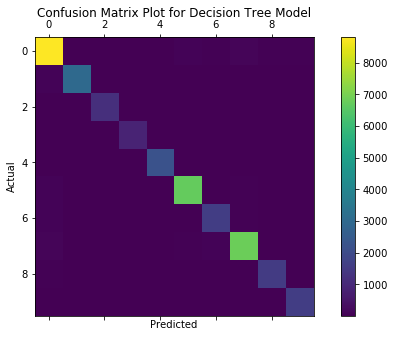

In [43]:
# plot of confusion matrix
plt.figure(figsize=(10,5))
plt.matshow(cm, fignum=1)

plt.title('Confusion Matrix Plot for Decision Tree Model')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()